In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import keras
from google.colab import files

In [17]:
def get_data_from_kaggle():
    ! pip install kaggle
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    !kaggle competitions download digit-recognizer
    # unzip the files
    ! unzip train.csv.zip
    ! unzip test.csv.zip

In [18]:
def plot_data(X):
    # plot first few images
    for i in range(9):
	    # define subplot
	    plt.subplot(330 + 1 + i)
	    img=X[i].reshape(28,28)
        # plot raw pixel data
	    plt.imshow(img, cmap=plt.get_cmap('gray'))
        # show the figure
    plt.show()

In [19]:
def prepare_data(X,y,test_size=0.1):
    x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=test_size,random_state=5)

    # reshape data
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
    x_val = x_val.reshape((x_val.shape[0], 28, 28, 1))

    # convert the output colums
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)

    # pixel normalization
    x_train, x_val = x_train.astype('float32'), x_val.astype('float32')
    x_train,x_val = x_train / 255.0, x_val / 255.0

    return x_train, x_val, y_train, y_val

In [20]:
def define_model(neurons):
    model = Sequential()
    # 1 ConV layer, then max pool, then flatten and feed into an ANN
    model.add(Conv2D(filters=32,kernel_size=(3,3),kernel_initializer='he_uniform',activation='relu',input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())

    # Dense layers
    #model.add(dropout=0.2)
    model.add(Dense(neurons, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
def train_model(x_train,y_train):
    scores, histories = list(), list()
    n_folds=3

    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=5)
    # enumerate splits
    count=0

    dense_neurons = [20,30,40]
    index=0

    for train_ix, test_ix in kfold.split(x_train):
	    # define model
        neurons = dense_neurons[index]
        model = define_model(neurons)
        index+=1
	
        print("-----Model with",neurons,"neurons in dense layer-----")
            # select rows for train and test
        trainX, trainY, testX, testY = x_train[train_ix], y_train[train_ix], x_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=1)

        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
    
        # store model
        name='/content/model_v'+str(count)+'.h5'
        model.save(name)
        count+=1
    
        # stores scores
        scores.append(acc)
        histories.append(history)
        print("\nA plot of the model's training curves:\n")
        visualizer(history)
        print("\n")
    index=scores.index(max(scores))
    return scores, histories, index

In [22]:
def visualizer(history):
    fig, axs = plt.subplots(1,3,figsize=(19,6))

    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'test'], loc='upper left')

    axs[1].axis('off')

    # summarize history for loss
    axs[2].plot(history.history['loss'])
    axs[2].plot(history.history['val_loss'])
    axs[2].set_title('model loss')
    axs[2].set_ylabel('loss')
    axs[2].set_xlabel('epoch')
    axs[2].legend(['train', 'test'], loc='upper left')

    plt.show()

In [23]:
def download_model(index):      # the model at index has the highest accuracy
    path="model_v"+str(index)+".h5"
    files.download(path)
    return path

In [24]:
def accuracy_score(y_pred,y_actual):
    count=0
    for i in range(len(y_pred)):
        pred = y_pred[i]
        actual = y_actual[i]
        flag=0

        for j in range(len(actual)):
            if actual[j]!=pred[j]:
                flag=1
                break
        if flag==0:
            count+=1

    return (count/len(y_actual))

In [25]:
def test_results(x_val,y_val,path):
    model = keras.models.load_model(path)
    y_pred = model.predict(x_val)

    # convert the prediction from probablity distribution to floor/ceiling floats
    for i in range(len(y_pred)):
        prediction = y_pred[i]
        for j in range(len(prediction)):
            if prediction[j]<0.9:
                prediction[j]=0.0
            else:
                prediction[j]=1.0
        y_pred[i] = prediction

    return accuracy_score(y_pred,y_val)*100

In [26]:
def driver_code():
    print("Start\n")
    get_data_from_kaggle()
    train_data=pd.read_csv('train.csv')

    y = train_data['label'].values
    X = train_data.iloc[:,1:].values

    plot_data(X)
    x_train, x_val, y_train, y_val = prepare_data(X,y)

    scores,histories,index = train_model(x_train,y_train)
    path = download_model(index)

    print("----Model %i, was chosen as the best model!----"%(index+1))

    result = test_results(x_val,y_val,path)
    print("Final accuracy:",result)

    print("\nEnd")

Start

 82% 5.00M/6.09M [00:00<00:00, 25.1MB/s]
100% 6.09M/6.09M [00:00<00:00, 24.2MB/s]
 55% 5.00M/9.16M [00:00<00:00, 6.03MB/s]
100% 9.16M/9.16M [00:00<00:00, 10.5MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 89.9MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


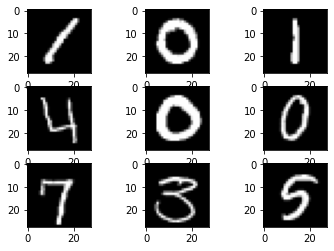

-----Model with 20 neurons in dense layer-----
Epoch 1/10
788/788 [==============================] - 19s 7ms/step - loss: 0.2650 - accuracy: 0.9169 - val_loss: 0.1285 - val_accuracy: 0.9623
Epoch 2/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0880 - accuracy: 0.9747 - val_loss: 0.0781 - val_accuracy: 0.9769
Epoch 3/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0618 - accuracy: 0.9812 - val_loss: 0.0694 - val_accuracy: 0.9793
Epoch 4/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0436 - accuracy: 0.9874 - val_loss: 0.0647 - val_accuracy: 0.9810
Epoch 5/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0351 - accuracy: 0.9895 - val_loss: 0.0631 - val_accuracy: 0.9819
Epoch 6/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0257 - accuracy: 0.9925 - val_loss: 0.0667 - val_accuracy: 0.9798
Epoch 7/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0217 - accuracy: 0.9938 

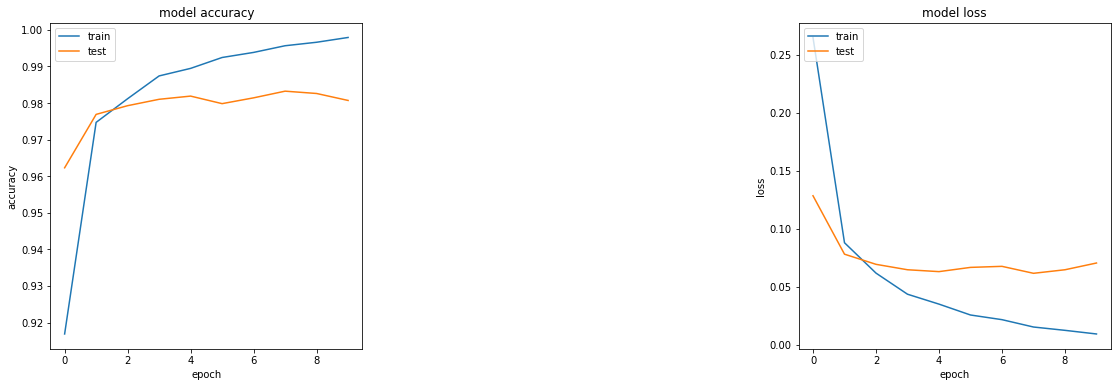



-----Model with 30 neurons in dense layer-----
Epoch 1/10
788/788 [==============================] - 6s 7ms/step - loss: 0.3067 - accuracy: 0.9029 - val_loss: 0.1421 - val_accuracy: 0.9585
Epoch 2/10
788/788 [==============================] - 5s 7ms/step - loss: 0.1014 - accuracy: 0.9695 - val_loss: 0.1049 - val_accuracy: 0.9685
Epoch 3/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0647 - accuracy: 0.9798 - val_loss: 0.1071 - val_accuracy: 0.9688
Epoch 4/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0476 - accuracy: 0.9848 - val_loss: 0.0769 - val_accuracy: 0.9779
Epoch 5/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0343 - accuracy: 0.9894 - val_loss: 0.0737 - val_accuracy: 0.9789
Epoch 6/10
788/788 [==============================] - 6s 8ms/step - loss: 0.0255 - accuracy: 0.9922 - val_loss: 0.0790 - val_accuracy: 0.9783
Epoch 7/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0192 - accuracy: 0.9944

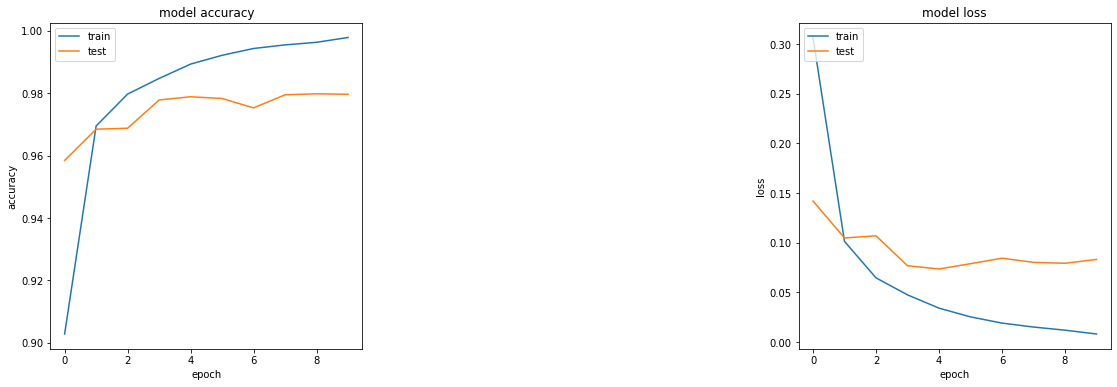



-----Model with 40 neurons in dense layer-----
Epoch 1/10
788/788 [==============================] - 6s 7ms/step - loss: 0.2804 - accuracy: 0.9137 - val_loss: 0.1404 - val_accuracy: 0.9596
Epoch 2/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0953 - accuracy: 0.9720 - val_loss: 0.0887 - val_accuracy: 0.9750
Epoch 3/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0586 - accuracy: 0.9827 - val_loss: 0.0886 - val_accuracy: 0.9739
Epoch 4/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0422 - accuracy: 0.9884 - val_loss: 0.0807 - val_accuracy: 0.9751
Epoch 5/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0316 - accuracy: 0.9913 - val_loss: 0.0810 - val_accuracy: 0.9768
Epoch 6/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0218 - accuracy: 0.9942 - val_loss: 0.0799 - val_accuracy: 0.9768
Epoch 7/10
788/788 [==============================] - 5s 7ms/step - loss: 0.0170 - accuracy: 0.9951

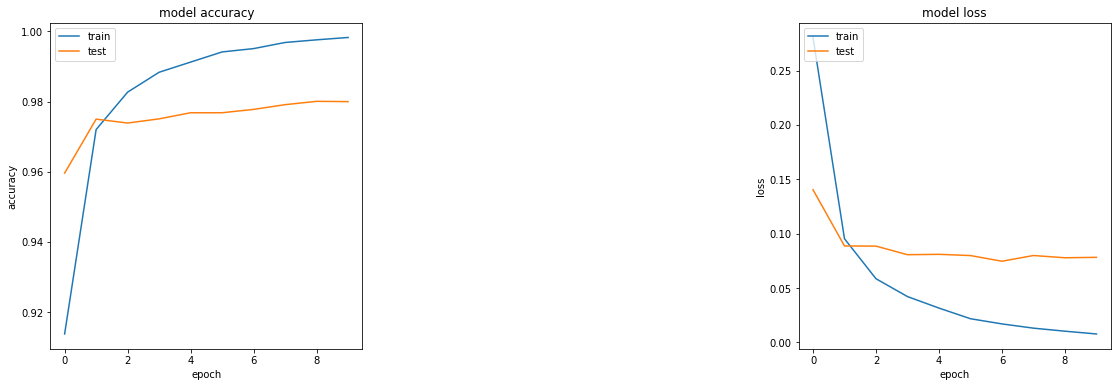

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

----Model 1, was chosen as the best model!----
Final accuracy: 95.4047619047619

End


In [27]:
driver_code()